# Setup

In [96]:
import os
import json
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import open_clip
import torch

sys.path.append('../satclip')
sys.path.append('../satclip/satclip')
import satclip
from satclip.load import get_satclip
from huggingface_hub import hf_hub_download

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from utils import get_species_names, format_species_name_CLIP, get_species_embeddings, read_csv_non_utf, \
                  count_parameters, get_train_test_split, preprocess_data, get_zero_nonzero_datasets
from species_embeddings import multi_species_extraction

In [3]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']

# Grabbing Benitez-Lopez
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)
ben_lop2019 = read_csv_non_utf(ben_lop_path)

# Trying out BioCLIP and thinking about integration
- Relevant pages for BioCLIP
   - [`open_clip` package documentation - base package](https://pypi.org/project/open-clip-torch/)
   - [BioCLIP model page on HuggingFace](https://huggingface.co/imageomics/bioclip) 

In [3]:
# Testing out on a toy dataset of scientific names
sci_names = ['Loxodonta africana', 'Odocoileus virginianus', 'Pandinus imperator']

# Reading in the pre-trained BioCLIP model
model, _, preprocess_val = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')

# Extracting the relevant info from ITIS
full_names = []
for name in sci_names:
    full_names.append(get_species_names(name))

In [4]:
# Processing with BioCLIP
species_embeddings = get_species_embeddings(full_names, model, tokenizer, full_hierarchy = True, common_name = False)

In [5]:
# Checking out the embeddings and the name strings that were processed
for k, v in species_embeddings.items():
    print(f'Species {k} has embedding of shape {v['embedding'].shape}')
    print(v['names_used'])
    print()

Species Loxodonta africana has embedding of shape (512,)
['a photo of Animalia Chordata Mammalia Proboscidea Elephantidae Loxodonta africana']

Species Odocoileus virginianus has embedding of shape (512,)
['a photo of Animalia Chordata Mammalia Artiodactyla Cervidae Odocoileus virginianus']

Species Pandinus imperator has embedding of shape (512,)
['a photo of Animalia Arthropoda Euchelicerata Scorpiones Scorpionidae Pandinus imperator']



In [6]:
# Seeing if elephants are more similar to deer than to scorpions as a basic sanity check
print(species_embeddings['Loxodonta africana']['embedding'].dot(species_embeddings['Odocoileus virginianus']['embedding']))
print(species_embeddings['Loxodonta africana']['embedding'].dot(species_embeddings['Pandinus imperator']['embedding']))

0.64558005
0.4450716


## Quality control on pre-computed species embeddings

In [64]:
# Reading in the saved embeddings
with open('../embeddings/bioclip_embeddings.json', 'r') as f:
    emb = json.load(f)

In [65]:
# Checking that all records are mammals
for name, dic in emb.items():
    for full_name in dic['names_used']:
        if 'Mammalia' not in full_name:
            print(name, full_name)

84


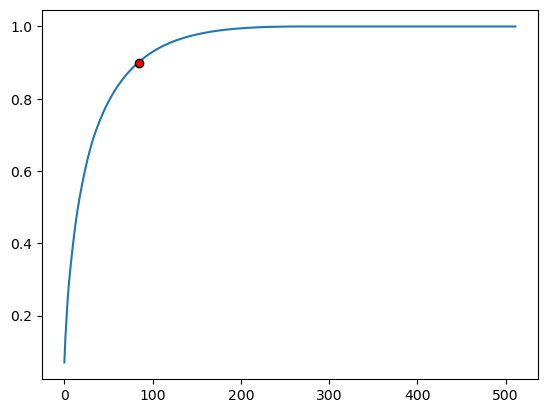

In [173]:
# BioCLIP: performing PCA on a toy train set
idxs = get_train_test_split(len(ben_lop2019))
train_data = mean_embs[idxs['train'], : ]
test_data = mean_embs[idxs['test'], : ]

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

pca = PCA()
train_pca = pca.fit_transform(train_data)
test_pcs = pca.transform(test_data)

# Plotting explained variance
var_cutoff = 0.9
exp_var = pca.explained_variance_ratio_.cumsum()
idx_cutoff = np.argmax(exp_var > var_cutoff)
print(idx_cutoff)

plt.plot(exp_var, zorder = 0)
plt.scatter(idx_cutoff, var_cutoff, color = 'red', edgecolor = 'black', zorder = 100);

# Misc. Testing

In [184]:
# Checking out of context if the reordeing method post-PCA works as intended in "get_all_embeddings"
np.random.seed(1693)

a = pd.DataFrame(np.random.randn(len(ben_lop2019), 10))
train = a.iloc[idxs['train']].values
test = a.iloc[idxs['test']].values

a_prime = np.vstack((train[ : , : 3], test[ : , : 3]))

cols = [f'TESTING_{i}' for i in range(a_prime.shape[1])]
a_pd = pd.DataFrame(a_prime, columns = cols)

a_pd.index = list(idxs['train']) + list(idxs['test'])
a_pd = a_pd.sort_index()

(a_pd.values != a.iloc[ : ,  : 3]).sum(axis = 0).sum()

0